In [2]:
import pandas as pd
import seaborn as sns

In [40]:
import numpy as np
from glob import glob
from json import loads

glob_path = "./implementation/test/history/**/*.json"

runs = []
for run_output_filepath in glob(glob_path, recursive=True):
    with open(run_output_filepath) as run_output:
        run_json = loads(run_output.read())
        runs.append(run_json)

if not runs:
    raise Exception("No runs found")
else:
    print(f"Found {len(runs)} runs")


df = pd.DataFrame(runs)
df = df.rename(columns={
    "lang": "language"
})

df = df.assign(
    # Super fragile replace but works for now
    payload=lambda df: df["payload"].map(
        lambda payload: loads(payload.replace(";", ","))),

    runtime=lambda df: df["runtime"].astype(float),
    roundTripTime=lambda df: df["roundTripTime"].astype(float),
    newcontainer=lambda df: df["newcontainer"].astype(int),

    filter=lambda df: df["payload"].map(
        lambda payload: f"{payload['filter']} x {payload.get('repeats', 1)}"),
    filename=lambda df: df["payload"].map(lambda payload: payload["key"]),
    container_state=lambda df: np.where(
        df["newcontainer"] == 1, "cold", "hot"
    ),
    language=lambda df: df["language"].map({
        "java": "Java",
        "node.js": "JavaScript",
    }),

    pixelDimensions=lambda df: df["filename"].map(
        lambda filename: tuple(map(int, filename.split("@")[0].split("x")))),
    pixelAmount=lambda df: df["pixelDimensions"].map(
        lambda dimensions: dimensions[0] * dimensions[1]),

    shortName=lambda df:
    df["filename"].map(lambda filename: filename.split("-")[1].strip()[:-4]),

    fileID=lambda df: df["shortName"] + " " + df["pixelDimensions"].astype(str),

)

Found 1126 runs


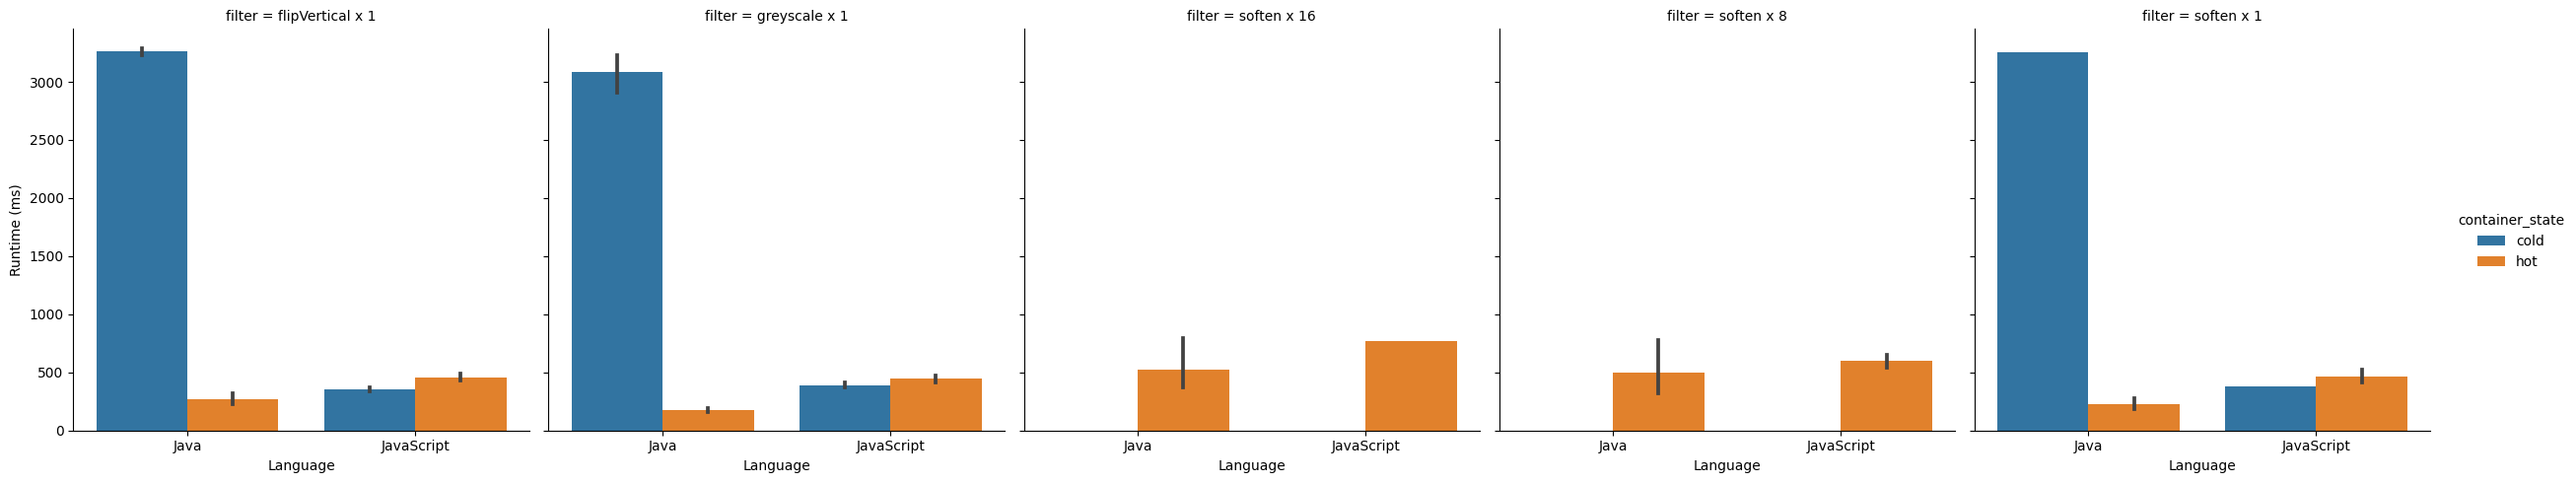

In [41]:
data = df

results = sns.catplot(
    data,
    kind="bar",
    x="language", y="runtime",
    hue="container_state",
    col="filter",
)
results.set_xlabels("Language")
results.set_ylabels("Runtime (ms)")

results

In [4]:
grouped_columns = [
    # "cpuType",
    "fileID", "filter", "container_state", "language",
]
runtime_results = df.groupby(grouped_columns)["runtime"] \
    .agg(["mean", "std", "count"])
runtime_results = runtime_results.rename(columns={
    "mean": "average runtime (ms)",
    "std": "standard deviation",
    "count": "sample size",
})

runtime_results

average runtime (ms)  \
fileID                 filter           container_state language                           
deathstar (1920, 1200) flipVertical x 1 cold            Java                 4115.000000   
                                                        JavaScript           1186.500000   
                                        hot             Java                  761.038462   
                                                        JavaScript           1318.000000   
                       greyscale x 1    cold            Java                 4084.000000   
...                                                                                  ...   
vietfood (700, 466)    soften x 1       cold            JavaScript            603.000000   
                                        hot             Java                  379.272727   
                                                        JavaScript            681.545455   
                       soften x 8       hot             Java                 1235.833333   
                                                        JavaScript           1141.333333   

                                                                    standard deviation  \
fileID                 filter           container_state language                         
deathstar (1920, 1200) flipVertical x 1 cold            Java                 39.597980   
                                                        JavaScript           10.606602   
                                        hot             Java                135.914526   
                                                        JavaScript          110.680148   
                       greyscale x 1    cold            Java                305.470129   
...                                                                                ...   
vietfood (700, 466)    soften x 1       cold            JavaScript                 NaN   
                                        hot             Java                114.370530   
                                                        JavaScript           90.889343   
                       soften x 8       hot             Java                601.300729   
                                                        JavaScript           49.653466   

                                                                    sample size  
fileID                 filter           container_state language                 
deathstar (1920, 1200) flipVertical x 1 cold            Java                  2  
                                                        JavaScript            2  
                                        hot             Java                 26  
                                                        JavaScript           22  
                       greyscale x 1    cold            Java                  2  
...                                                                         ...  
vietfood (700, 466)    soften x 1       cold            JavaScript            1  
                                        hot             Java                 11  
                                                        JavaScript           11  
                       soften x 8       hot             Java                  6  
                                                        JavaScript            6  

[84 rows x 3 columns]

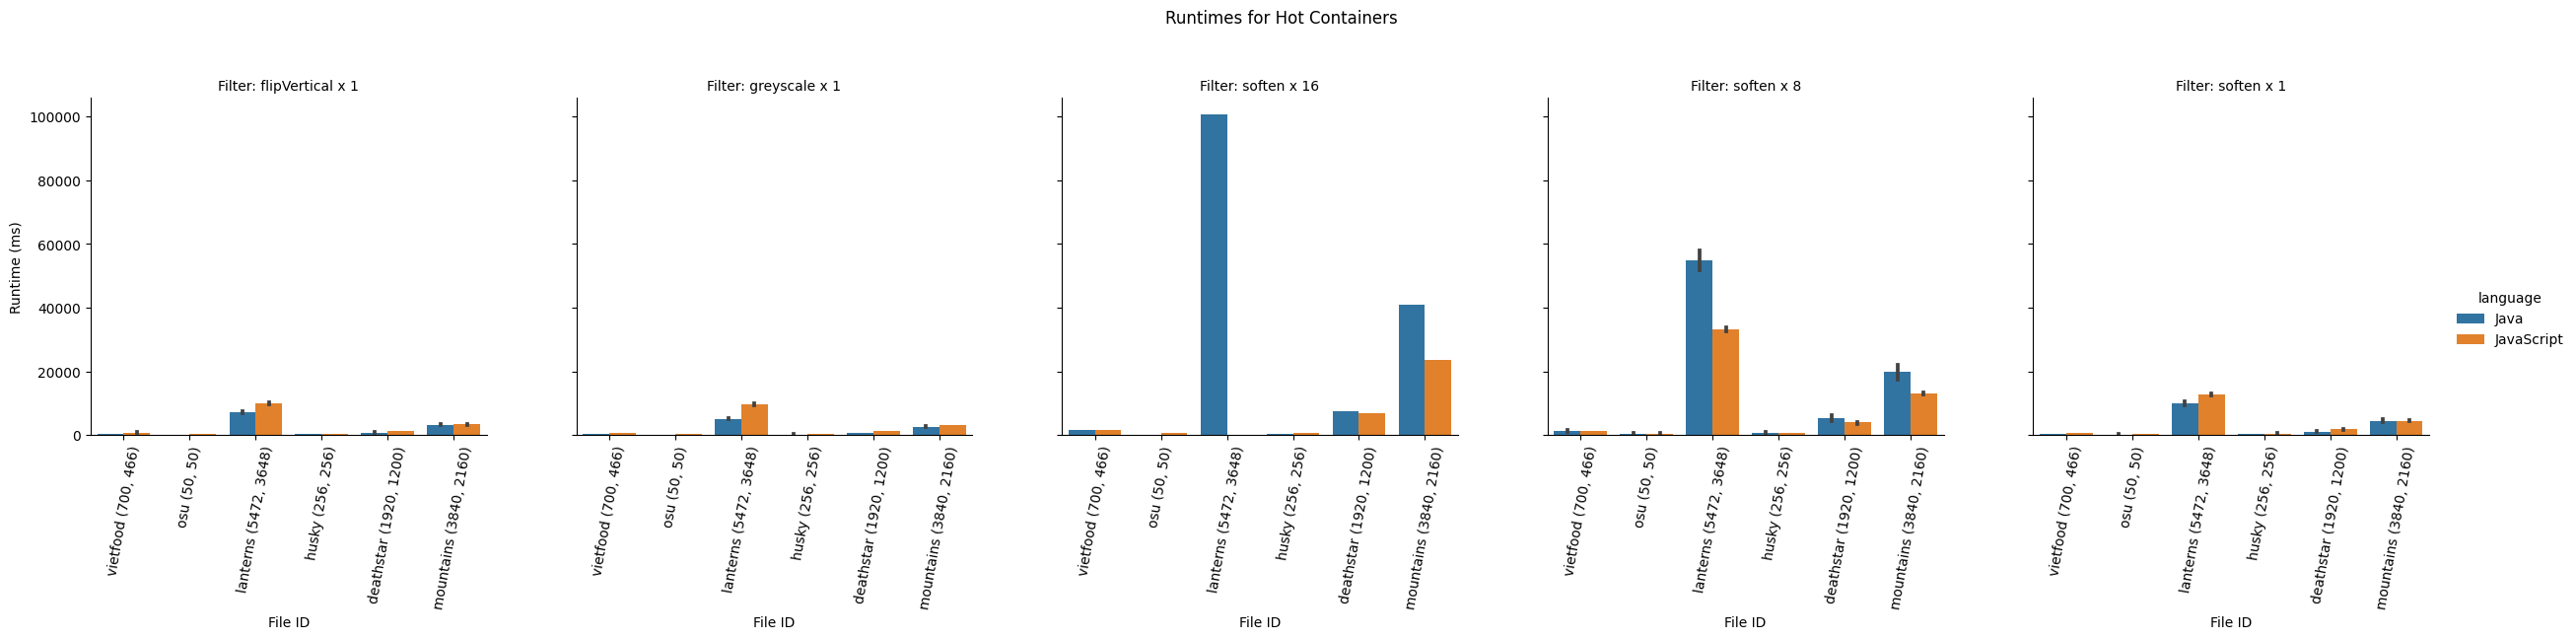

In [13]:
hot_results = sns.catplot(
    df[df["container_state"] == "hot"], x="fileID", y="runtime", hue="language",
    col="filter", kind="bar",
)
hot_results.set_axis_labels("File ID", "Runtime (ms)")
hot_results.set_titles("Filter: {col_name}")
hot_results.figure.subplots_adjust(top=0.8)
hot_results.figure.suptitle("Runtimes for Hot Containers")
hot_results.set_xticklabels(rotation=80)

hot_results

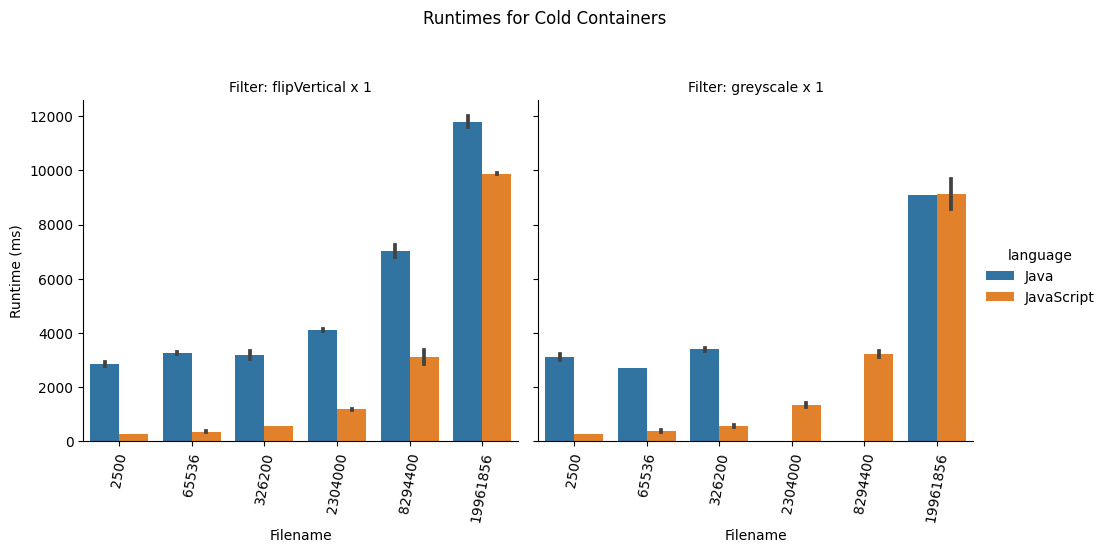

In [107]:
cold_results = sns.catplot(
    df[df["container_state"] == "cold"], x="pixelAmount", y="runtime", hue="language",
    col="filter", kind="bar",
)
cold_results.set_axis_labels("Filename", "Runtime (ms)")
cold_results.set_titles("Filter: {col_name}")
cold_results.figure.subplots_adjust(top=0.8)
cold_results.figure.suptitle("Runtimes for Cold Containers")
cold_results.set_xticklabels(rotation=80)

cold_results

Text(0.5, 0.98, 'Runtimes for Hot/Cold Containers')

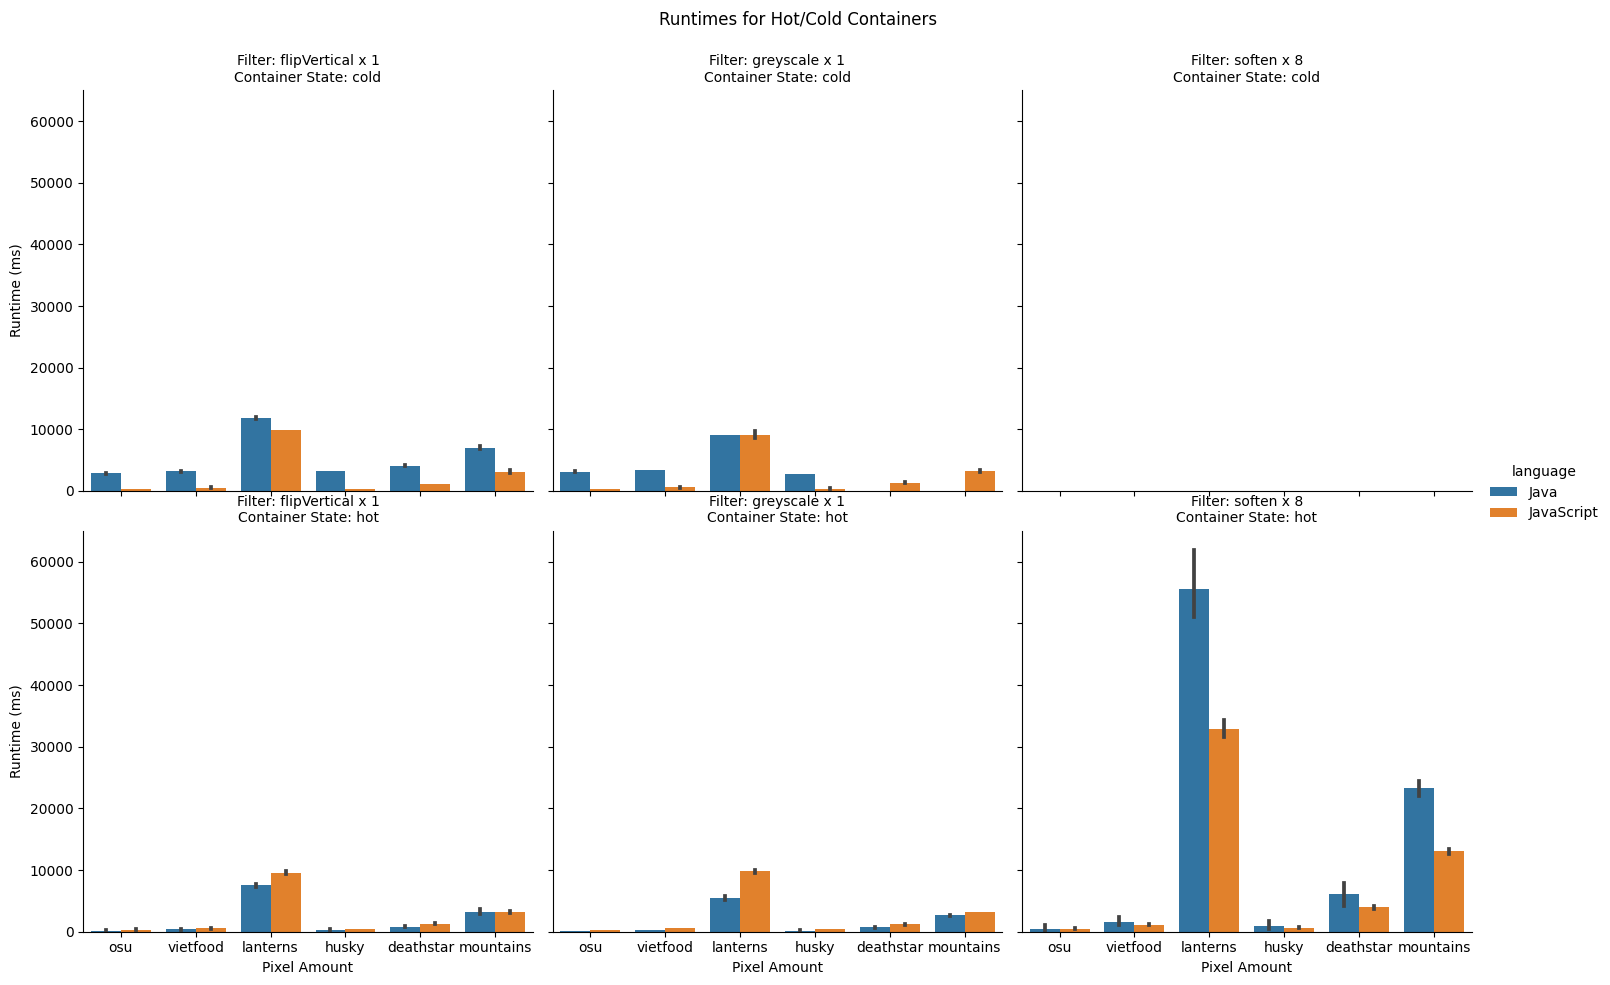

In [115]:
hot_cold_results = sns.catplot(
    df, x="shortName", y="runtime", hue="language",
    col="filter", row="container_state", kind="bar",
)
hot_cold_results.set_axis_labels("Pixel Amount", "Runtime (ms)")
hot_cold_results.set_titles("Filter: {col_name}\nContainer State: {row_name}")
hot_cold_results.figure.subplots_adjust(top=0.9)
hot_cold_results.figure.suptitle("Runtimes for Hot/Cold Containers")

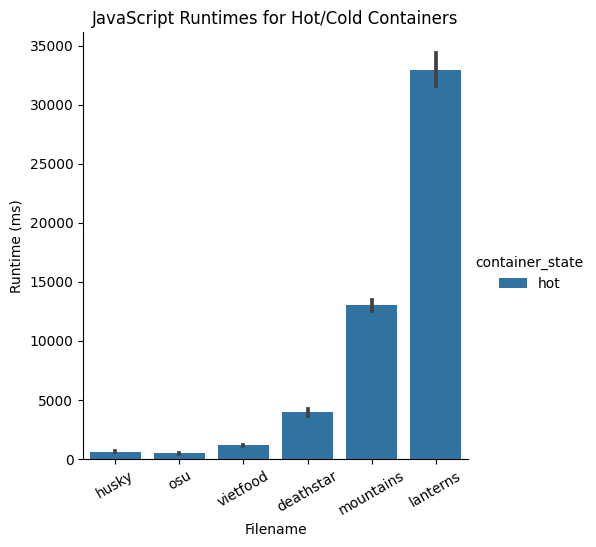

In [126]:
hot_cold_javascript = sns.catplot(
    df[
        (df["language"] == "JavaScript")
        & (df["filter"] == "soften")
    ],
    x="shortName", y="runtime",
    hue="container_state",
    kind="bar",
)
hot_cold_javascript.set(title="JavaScript Runtimes for Hot/Cold Containers")
hot_cold_javascript.set_xlabels("Filename")
hot_cold_javascript.set_ylabels("Runtime (ms)")
hot_cold_javascript.set_xticklabels(rotation=30)

hot_cold_javascript